In [32]:
import solvers
from matplotlib import pyplot as plt
import numpy as np
import functions
import datetime
import FEM

In [33]:
sargs = [0,'1','0', 2]

mode = 'bugfix'
if len(sargs)>1:
    mode = {'0':'bugfix',
            '1':'quick_test',
            '2':'full_test'}[sargs[1]]
else:
    print('No mode specified')
    print('add arg for mode:')
    print('0: bufix (default)')
    print('1: quick_test')
    print('2: full_test')
    print('syntax e.g.: python testing.py 2')




def set_args(mode=mode):
    print(f'\nTesting with mode "{mode}"...')
    global Ne, time_steps, NNkwargs, NoM
    if mode == 'bugfix':
        Ne = 5
        time_steps = 20
        NNkwargs = {'l':4,'n':20,'lr':5e-3,'patience':[10,20]}
        NoM = 2
    elif mode == 'quick_test':
        Ne = 20
        time_steps = 20
        NNkwargs = {'l':6,'n':80, 'lr':8e-5, 'epochs': [100,100], 'patience':[20,30]}
        NoM=3
    elif mode == 'full_test':
        Ne = 20
        time_steps =500
        NNkwargs = {'l':6,'n':80, 'lr':1e-5, 'epochs': [100,100], 'patience':[20,40], 'noise_level':0}
        NoM=1

set_args()

if len(sargs)>2:
    if sargs[2]=='f':
        source = True 
    elif sargs[2]=='0':
        source = False
    else:
        print('failed reading source term')
        source = True
else:
    source = True
print('Using exact source' if source else 'Using unknown source (i.e. guessing zero)')

if len(sargs)>3:
    p = int(sargs[3])
else:
    p=1
print(f'Using p={p}')



Testing with mode "quick_test"...
Using unknown source (i.e. guessing zero)
Using p=2


sol: 4

--- making data set for alpha 0.1 ---
--- making data set for alpha 0.2 ---
--- making data set for alpha 0.3 ---
--- making data set for alpha 0.4 ---
--- making data set for alpha 0.5 ---
--- making data set for alpha 0.6 ---
--- making data set for alpha 0.9 ---
--- making data set for alpha 1 ---
--- making data set for alpha 1.2 ---
--- making data set for alpha 1.3 ---
--- making data set for alpha 1.4 ---
--- making data set for alpha 1.6 ---
--- making data set for alpha 1.7 ---
--- making data set for alpha 1.8 ---
--- making data set for alpha 1.9 ---
--- making data set for alpha 2 ---
--- making data set for alpha 0.8 ---
--- making data set for alpha 1.1 ---

Time making data set: 0:00:07.121199

Time training ham NNs: 0:00:33.013549

Time training all NNs: 0:01:25.822228


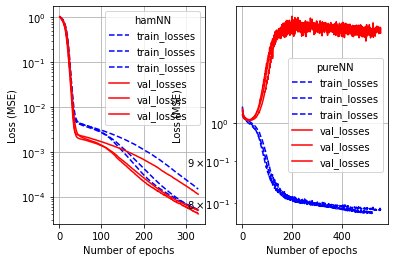

In [34]:
femscores = []
costascores = []
pnnscores = []

sol = 4

print(f'sol: {sol}\n')
model = solvers.Solvers(p=p,sol=sol, unknown_source = not source, Ne=Ne, time_steps=time_steps, T=5, NoM=NoM, **NNkwargs)
extra_tag = ''#_long_training'#'' # for different names when testing specific stuff
figname = f'../preproject/1d_heat_figures/{"known_f" if source else "unknown_f"}/interpol/loss_sol{sol}_{mode}_p{p}{extra_tag}.pdf'
#figname = ''
model.plot=True
model.train(figname=figname)



In [35]:
def data_set(self,alphas, set_norm_params=False): # Not shuffled!!!
    ham_data=np.zeros((self.time_steps*len(alphas),self.Np+self.nfeats + self.Np)) # data for ham NN model
    pnn_data=np.zeros((self.time_steps*len(alphas),self.Np+self.nfeats + self.Np)) # data for pure NN model
    for i, alpha in enumerate(alphas):
        print(f'--- making data set for alpha {alpha} ---')
        f, u_ex = functions.sbmfact(alpha=alpha)[self.sol]
        if self.unknown_source:
            f=FEM.zero
        fem_model = FEM.Heat(self.tri, f, self.p, u_ex, k=self.T/self.time_steps)
        for t in range(self.time_steps):
            ex_step = fem_model.u_ex(fem_model.tri, t=fem_model.time) # exact solution before step
            ##prev_ex_step = fem_model.u_ex(fem_model.tri, t=fem_model.time-fem_model.k) ## diff_test
            pnn_data[i*self.time_steps+t,:self.Np] = ex_step
            ##pnn_data[i*self.time_steps+t,:self.Np] = ex_step - prev_ex_step ## diff_test
            ##pnn_data[i*self.time_steps+t,0] = fem_model.u_ex(0, t=fem_model.time+fem_model.k) ## bdry_shift_test
            ##pnn_data[i*self.time_steps+t,self.Np-1] = fem_model.u_ex(1, t=fem_model.time+fem_model.k) ## bdry_shift_test
            fem_model.u_fem = ex_step # Use u_ex as u_prev
            fem_model.step() # make a step
            ham_data[i*self.time_steps+t,:self.Np] = fem_model.u_fem
            if self.alpha_feature:
                ham_data[i*self.time_steps+t,self.Np:self.Np+self.nfeats] = alpha # more/less features could be tried
                pnn_data[i*self.time_steps+t,self.Np:self.Np+self.nfeats] = alpha # more/less features could be tried
            ex_step = fem_model.u_ex(fem_model.tri, t=fem_model.time) # exact solution after step
            error = ex_step - fem_model.u_fem
            pnn_data[i*self.time_steps+t, self.Np+self.nfeats:] = ex_step
            ham_data[i*self.time_steps+t, self.Np+self.nfeats:] = fem_model.MA @ error # residual
            #if t%100==4:
            #    print('err and res')
            #    print(error)
            #    #print(fem_model.MA)
            #    print(ham_data[i*self.time_steps+t, self.Np+self.nfeats:])
            #    print(fem_model.F)
            #    print(fem_model.k)
            #    print(fem_model.T)
    #np.random.shuffle(ham_data)
    #np.random.shuffle(pnn_data)
    X = ham_data[:,:self.Np+self.nfeats]
    Y = ham_data[:,self.Np+self.nfeats+1:-1]
    pnnX = pnn_data[:,:self.Np+self.nfeats]
    pnnY = pnn_data[:,self.Np+self.nfeats+1:-1]
    #print(X)
    if set_norm_params: # only training set, not val
        self.ham_mean = np.mean(X) if self.normalize else 0
        self.ham_var = np.var(X) if self.normalize else 1
        self.pnn_mean = np.mean(pnnX) if self.normalize else 0
        self.pnn_var = np.var(pnnX) if self.normalize else 1
        #print('mean, var = ',self.mean, self.var)
    X = X-self.ham_mean
    X = X/self.ham_var**0.5
    pnnX = pnnX-self.pnn_mean
    pnnX = pnnX/self.pnn_var**0.5
    #print(X)
    X[:,1:-1] += np.random.rand(self.time_steps*len(alphas),self.Np-2)*self.noise_level-self.noise_level/2
    pnnX[:,1:-1] += np.random.rand(self.time_steps*len(alphas),self.Np-2)*self.noise_level-self.noise_level/2
    return X,Y, pnnX, pnnY

def plot_one_step_sources(self):
    X, Y, pnnX, pnnY = data_set(self, self.alpha_train, set_norm_params=True)
    X_val, Y_val, pnnX_val, pnnY_val = data_set(self, self.alpha_val)
    X_test, Y_test, pnnX_test, pnnY_test = data_set(self, self.alpha_val)
    # Plot some source terms
    for i in range(3):
        t = np.random.randint(self.time_steps)
        k=self.T/self.time_steps
        time=t*k
        f, u_ex = functions.sbmfact(alpha=self.alpha_train[0])[self.sol]
        plt.plot(self.tri[1:-1], Y[t], 'k',  label='exact source')
        plt.plot(self.tri, f(x=self.tri, t=time)*k/Ne, 'yx',  label='exact source2')
        for model in self.hamNNs:
            plt.plot(self.tri[1:-1], model(np.array([X[t]]))[0], 'r--',  label='ham source')
        plt.legend(title='trainset')
        plt.grid()
        plt.savefig(f'../preproject/1d_heat_figures/{self.sol}_source_train_{t}.pdf')
        plt.show()

        t = np.random.randint(self.time_steps)
        time=t*k
        f, u_ex = functions.sbmfact(alpha=self.alpha_val[0])[self.sol]
        plt.plot(self.tri[1:-1], Y_val[t], 'k',  label='exact source')
        plt.plot(self.tri, f(x=self.tri, t=time)*k/Ne, 'yx',  label='exact source2')

        for model in self.hamNNs:
            plt.plot(self.tri[1:-1], model(np.array([X_val[t]]))[0], 'r--',  label='ham source')
        plt.legend(title='valset')
        plt.grid()
        plt.savefig(f'../preproject/1d_heat_figures/{self.sol}_source_val_{t}.pdf')
        plt.show()

        t = np.random.randint(self.time_steps)
        time=t*k
        f, u_ex = functions.sbmfact(alpha=self.alpha_val[0])[self.sol]
        plt.plot(self.tri[1:-1], Y_test[t], 'k',  label='exact source')
        plt.plot(self.tri, f(x=self.tri, t=time)*k/Ne, 'yx',  label='exact source2')

        for model in self.hamNNs:
            plt.plot(self.tri[1:-1], model(np.array([X_test[t]]))[0], 'r--',  label='ham source')
        plt.legend(title='testset')
        plt.grid()
        plt.savefig(f'../preproject/1d_heat_figures/{self.sol}_source_test_{t}.pdf')
        plt.show()

        # PNN 
        plt.plot(self.tri[1:-1], pnnY[t], 'k',  label='exact temp')
        for model in self.pureNNs:
            plt.plot(self.tri[1:-1], model(np.array([pnnX[t]]))[0], 'r--',  label='pnn temp')
        plt.legend(title='trainset')
        plt.grid()
        plt.savefig(f'../preproject/1d_heat_figures/{self.sol}_temp_train_{t}.pdf')
        plt.show()

        plt.plot(self.tri[1:-1], pnnY_val[t], 'k',  label='exact temp')
        for model in self.pureNNs:
            plt.plot(self.tri[1:-1], model(np.array([pnnX_val[t]]))[0], 'r--',  label='pnn temp')
        plt.legend(title='valset')
        plt.grid()
        plt.savefig(f'../preproject/1d_heat_figures/{self.sol}_temp_val_{t}.pdf')
        plt.show()

        plt.plot(self.tri[1:-1], pnnY_test[t], 'k',  label='exact temp')
        for model in self.pureNNs:
            plt.plot(self.tri[1:-1], model(np.array([pnnX_test[t]]))[0], 'r--',  label='pnn temp')
        plt.legend(title='testset')
        plt.grid()
        plt.savefig(f'../preproject/1d_heat_figures/{self.sol}_temp_test_{t}.pdf')
        plt.show()
#plot_one_step_sources(self=model)
#print(model.noise_level)

In [36]:
def call_and_plot_one_step(self, alpha=None, model_index=0):
    NN = self.hamNNs[model_index]
    if alpha == None:
        alpha = self.alpha_test[0]
    X=np.zeros((1,self.Np+self.nfeats))
    f, u_ex = functions.sbmfact(alpha=alpha)[self.sol]
    if self.unknown_source:
        f_backup = f # for source plotting
        f=FEM.zero
    fem_model = FEM.Heat(self.tri, f, self.p, u_ex, k=self.T/self.time_steps)
    fem_model.u_fem =fem_model.u_ex(fem_model.tri, t=fem_model.time)
    for t in range(self.time_steps):
        u_prev = fem_model.u_fem # save previous solution
        uprevstr = str(u_prev)
        fem_model.step() # first, uncorrected, step
        fem_step = fem_model.u_fem
        X[:,:self.Np] = fem_step
        if self.alpha_feature:
            X[:,-1] = alpha
        X = (X-self.ham_mean)/self.ham_var**0.5
        correction = np.zeros(self.Np)
        correction[1:-1] = NN(X)[0,:]
        correction = correction*self.ham_Y_var**0.5
        correction = correction + self.ham_Y_mean
        if 1:#fem_model.u_fem.sum() < 1e10:
            fem_model.u_fem = u_prev
            fem_model.time -= fem_model.k # set back time for correction
            fem_model.step(correction=correction) # corrected step
        #print(fem_model.u_fem.sum())
        if 0:#t%1 == 0:
            plt.close()
            plt.plot(fem_model.tri, fem_model.u_fem, 'r', label='fem')
            plt.plot(fem_model.tri, fem_model.u_ex(t=fem_model.time, x=fem_model.tri), 'k--', label='ex')
            plt.legend(title=f'{t}')
            plt.show()
            print(fem_model.u_fem)
            plt.plot(fem_model.tri, correction, 'r', label='fem source')
            plt.plot(fem_model.tri, f_backup(x=fem_model.tri, t=t*fem_model.k)*fem_model.k/Ne, 'k--', label='exact source')
            plt.grid()
            plt.legend()
            plt.show()
        
        #if t%6==0:
        #    fem_model.u_fem = fem_model.u_ex(t=fem_model.time, x=fem_model.tri)

        #if t>18:
        #    break
        if abs(fem_model.u_fem).sum() > 1e10:
            print(self.ham_mean, self.ham_var)
            print('nan detected, step', t)
            print('\n')
            print(u_prev)
            print(uprevstr)
            print(correction)
            break
    return fem_model.u_fem



def test(self, interpol = True, figname=None):
    stat_plot_threshold = 2

    start_time = datetime.datetime.now()
    alphas = self.alpha_test_interpol if interpol else self.alpha_test_extrapol
    fem_score = {}
    fem_score_tri = {}
    costa_score = {}
    costa_score_tri = {}
    pnn_score = {}
    pnn_score_tri = {}
    fig, axs = plt.subplots(1,len(alphas))
    for i, alpha in enumerate([alphas[0]]):
        f, u_ex = functions.sbmfact(T=self.T,alpha=alpha)[self.sol]
        if self.unknown_source:
            f=FEM.zero
        
        # Solve with FEM
        fem_model = FEM.Heat(self.tri, f, self.p, u_ex, k=self.T/self.time_steps)
        fem_model.solve(self.time_steps, T = self.T)
        tri_fine = np.linspace(0,1,self.Ne*self.p*8+1)
        axs[i].plot(tri_fine, fem_model.solution(tri_fine), 'b', label='fem')
        fem_score[f'{alpha}'] = fem_model.relative_L2()
        fem_score_tri[f'{alpha}'] = np.sqrt(np.mean((fem_model.u_fem-fem_model.u_ex(self.tri,self.T))**2)) / np.sqrt(np.mean(fem_model.u_ex(self.tri,self.T)**2))

        # Solve with HAM
        hamgraphs=[]
        for m in range(self.NoM):
            fem_model.u_fem =self(alpha, model_index=m) # store in fem_model for easy use of relative_L2 and soltion functoins
            hamgraphs.append(fem_model.solution(tri_fine))
            
            if self.NoM <= stat_plot_threshold:
                axs[i].plot(tri_fine, fem_model.solution(tri_fine), 'g', label='costa' if m==0 else None)
            
            costa_score[f'{alpha},{m}'] = fem_model.relative_L2()
            costa_score_tri[f'{alpha},{m}'] = np.sqrt(np.mean((fem_model.u_fem-fem_model.u_ex(self.tri,self.T))**2)) / np.sqrt(np.mean(fem_model.u_ex(self.tri,self.T)**2))

        #break
        # Solve with DNN
        pnngraphs=[]
        for m in range(self.NoM):
            fem_model.u_fem =self.call_PNN(alpha, model_index=m) # store in fem_model for easy use of relative_L2 and soltion functoins
            pnngraphs.append(fem_model.solution(tri_fine))
            
            if self.NoM <= stat_plot_threshold:
                axs[i].plot(tri_fine, fem_model.solution(tri_fine), 'y', label='pureNN' if m==0 else None)
            
            pnn_score[f'{alpha},{m}'] = fem_model.relative_L2()
            pnn_score_tri[f'{alpha},{m}'] = np.sqrt(np.mean((fem_model.u_fem-fem_model.u_ex(self.tri,self.T))**2)) / np.sqrt(np.mean(fem_model.u_ex(self.tri,self.T)**2))


        if self.NoM > stat_plot_threshold:
            hamgraphs = np.array(hamgraphs)
            pnngraphs = np.array(pnngraphs)

            mean = np.mean(hamgraphs, axis=0)
            std = np.std(hamgraphs, axis=0, ddof=1)
            axs[i].plot(tri_fine, mean, 'g')
            axs[i].fill_between(tri_fine, mean+std, mean-std, color='g', alpha = 0.4, label = 'ham')
            
            mean = np.mean(pnngraphs, axis=0)
            std = np.std(pnngraphs, axis=0, ddof=1)
            axs[i].plot(tri_fine, mean, 'y')
            axs[i].fill_between(tri_fine, mean+std, mean-std, color='y', alpha = 0.4, label = 'pnn')

        axs[i].plot(tri_fine, u_ex(tri_fine), 'k--', label='exact')
        axs[i].grid()
        axs[i].legend(title=f'sol={self.sol},a={alpha}')

    print(f'\nTime testing: {datetime.datetime.now()-start_time}')
    print('')
    print('FEM L2 errors:', fem_score)
    print('CoSTA L2 errors:', costa_score)
    #print('PureNN L2 errors:', pnn_score)
    print('FEM l2 errors:', fem_score_tri)
    print('CoSTA l2 errors:', costa_score_tri)
    #print('PureNN l2 errors:', pnn_score_tri)
    print('')
    if figname != None:
        plt.savefig(figname)
    if self.plot:
        plt.show()
    else:
        plt.close()
    if 1:#statplot: # only last alpha, do this in a cleaner way! TODO
        hamgraphs = np.array(hamgraphs)
        pnngraphs = np.array(pnngraphs)

        mean = np.mean(hamgraphs, axis=0)
        std = np.std(hamgraphs, axis=0, ddof=1)
        #plt.plot(tri_fine, mean)
        plt.fill_between(tri_fine, mean+std, mean-std, color='g', alpha = 0.4)
        
        mean = np.mean(pnngraphs, axis=0)
        std = np.std(pnngraphs, axis=0, ddof=1)
        #plt.plot(tri_fine, mean)
        plt.fill_between(tri_fine, mean+std, mean-std, color='y', alpha = 0.4)
        plt.show()
        
    return fem_score_tri, costa_score_tri, pnn_score_tri


Time testing: 0:00:06.428068

FEM L2 errors: {'0.7': 0.43423690080215527, '1.5': 0.7470002435983624}
CoSTA L2 errors: {'0.7,0': 0.0009711839513562022, '0.7,1': 0.0005417294565996645, '0.7,2': 0.0013510642217796195, '1.5,0': 0.0018944447948934192, '1.5,1': 0.0008367261095605698, '1.5,2': 0.0018486410852401366}
PureNN L2 errors: {'0.7,0': 0.056615697013037064, '0.7,1': 0.08783315266318245, '0.7,2': 0.4969054920221764, '1.5,0': 0.6298747876456996, '1.5,1': 0.07512965678395908, '1.5,2': 0.8256381088373308}
FEM l2 errors: {'0.7': 0.4225715865446968, '1.5': 0.7232986030857148}
CoSTA l2 errors: {'0.7,0': 0.0009447100142367758, '0.7,1': 0.000526854049743774, '0.7,2': 0.0013148819835191534, '1.5,0': 0.0018332512909730665, '1.5,1': 0.0007991783182726808, '1.5,2': 0.0017823450037292507}
PureNN l2 errors: {'0.7,0': 0.06368108883179541, '0.7,1': 0.08723300035361566, '0.7,2': 0.48250744278348223, '1.5,0': 0.6087234522270458, '1.5,1': 0.07242153611893096, '1.5,2': 0.7960049911708595}



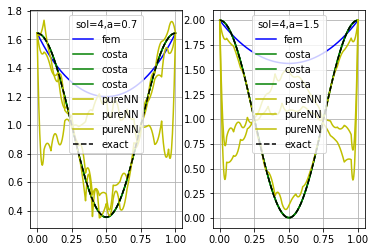

In [37]:
_ = model.test(interpol = True, figname=None)


Time testing: 0:00:03.298090

FEM L2 errors: {'0.7': 0.43423690080215527}
CoSTA L2 errors: {'0.7,0': 0.0009711839513562022, '0.7,1': 0.0005417294565996645, '0.7,2': 0.0013510642217796195}
FEM l2 errors: {'0.7': 0.4225715865446968}
CoSTA l2 errors: {'0.7,0': 0.0009447100142367758, '0.7,1': 0.000526854049743774, '0.7,2': 0.0013148819835191534}



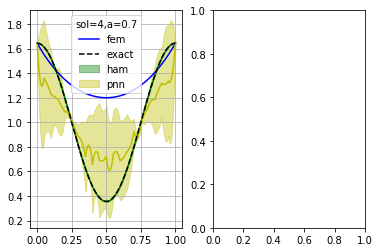

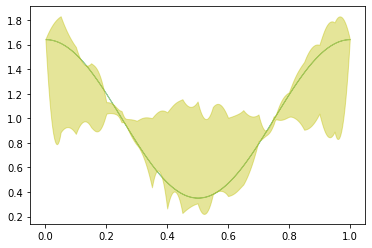

In [38]:

_ = test(model,interpol = True, figname=None)

#model.plot=True
#fs, cs = model.test()
#femscores.append([fs[k] for k in fs])
#costascores.append([cs[k] for k in cs])
#model.plot=True
figname = f'../preproject/1d_heat_figures/{"known_f" if source else "unknown_f"}/interpol/sol{sol}_{mode}_p{p}{extra_tag}.pdf'
#figname = ''
_ = model.test(interpol = True, figname=figname)
#figname = f'../preproject/1d_heat_figures/{"known_f" if source else "unknown_f"}/extrapol/sol{sol}_{mode}_p{p}{extra_tag}.pdf'
#figname = ''
#_ = model.test(interpol = False, figname=figname)
